# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [40]:
from tqdm.notebook import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [41]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.prepare_dataset import PrepareDataset

In [42]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths Setup

In [43]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [44]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [45]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [46]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("yolov8")        

## Load images from directory

In [47]:

prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.get_dataset()

  0%|          | 0/6930 [00:00<?, ?it/s]

In [48]:
len(train_images), len(train_class_ids), len(train_bboxes)

(15296, 15296, 15296)

Random samples: [3226, 8679, 5409, 14276, 11551, 12854, 14040, 5514, 6703]


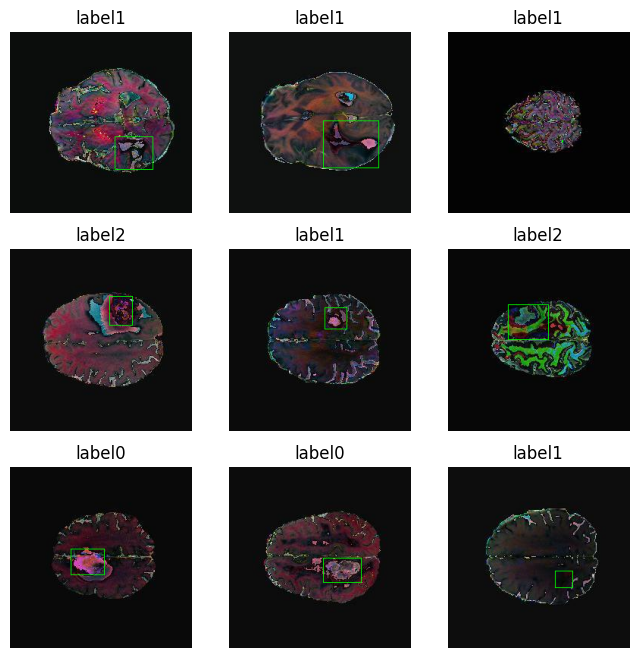

In [49]:
plot_random_images_bbox(image_paths=train_images, 
                        class_ids=train_class_ids, 
                        bboxes=train_bboxes,
                        class_map=class_map)

## Rebalance dataset by Down sempling to dataset with min images

In [50]:
rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets()
len(train_images), len(train_class_ids), len(train_bboxes)

[INFO] Unique class ids: [0 1 2], value counts: [4338 6836 4122]


(15296, 15296, 15296)

Random samples: [5733, 5487, 2734, 3092, 8283, 6420, 9876, 9547, 2238]


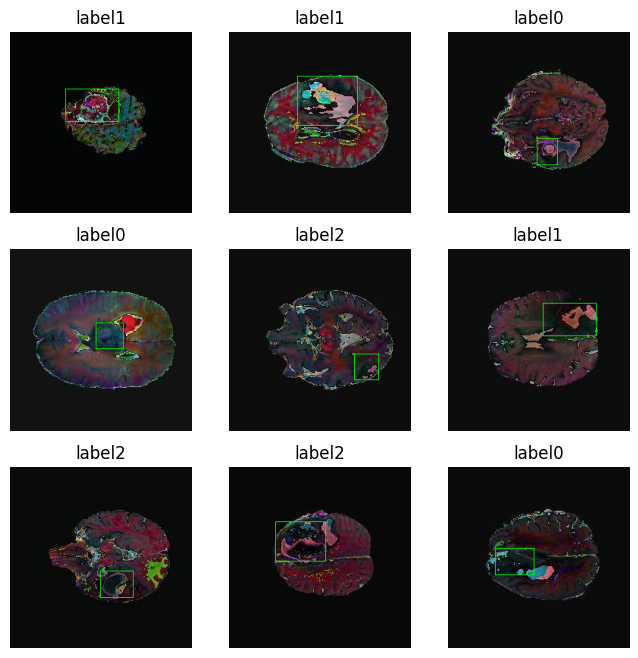

In [51]:
plot_random_images_bbox(image_paths=rebal_train_images,
                        class_ids=rebal_train_class_ids,
                        bboxes=rebal_train_bboxes,
                        class_map=class_map)

In [52]:
train_datasets = tf.data.Dataset.from_tensor_slices(
    (rebal_train_images, rebal_train_class_ids, rebal_train_bboxes))


In [53]:
len(train_datasets)

12366

In [54]:
for batch in train_datasets.take(1):
    print(batch)

(<tf.Tensor: shape=(), dtype=string, numpy=b'datasets/brain-tumor-2/train/images/volume_199_slice_104_jpg.rf.8c83f0f369ce7fcedb11e48212569900.jpg'>, <tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.675     , 0.43125   , 0.18333334, 0.10416666], dtype=float32)>)


In [55]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset( image_path, classes, bbox):
    images = load_image(image_path)
    return   tf.cast(images, tf.float32), tf.cast(classes, tf.int32), tf.cast(bbox, tf.float32) 
    # return   tf.cast(images, tf.float32), tf.one_hot(classes,NUM_CLASSES), bbox

### Augmentation

In [56]:
import albumentations as A

In [78]:

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSizedBBoxSafeCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.5)
], bbox_params=A.BboxParams(format='yolo8', label_fields=['bboxes']))

def augment_data(image,  bboxes):
    image = image.numpy()
    bboxes = bboxes.numpy()
    # labels = labels.numpy()
    # labels = tf.argmax(labels, axis=-1).numpy()  # Convert one-hot to class indices
    augmented = transform(image=image, bboxes=[bboxes])
    # augmented_labels = tf.one_hot(augmented['labels'], depth=NUM_CLASSES) ## Convert back to one-hot
    return augmented['image'], augmented['bboxes'],

def tf_augment_data(image, labels, bboxes ):
    aug_image, aug_bboxes = tf.py_function(augment_data, [image, bboxes], [tf.float32, tf.float32])
    aug_image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    aug_bboxes.set_shape((4,))
    
    return aug_image, (tf.one_hot(labels, depth=NUM_CLASSES), aug_bboxes)

In [79]:
train_ds = train_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)

In [80]:
for batch in train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(240, 240, 3), dtype=float32, numpy=
array([[[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.]],

       [[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.]],

       [[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.]],

       ...,

       [[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.]],

       [[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.]],

       [[ 7., 11., 10.],
        [ 7., 11., 10.],
        [ 7., 11., 10.],
        ...,
        [ 7., 11.,

In [81]:

train_ds = train_ds.map(tf_augment_data) 

In [82]:

train_ds = train_ds.shuffle(BATCH_SIZE * 4, reshuffle_each_iteration=True)\
                                .repeat() \
                                .batch(BATCH_SIZE, drop_remainder=True)\
                                .prefetch(tf.data.AUTOTUNE)


### Validation datasets setup

In [83]:
prepare_valid_datasets = PrepareDataset(image_dir=VALID_IMAGE_DIR,
                                label_dir=VALID_LABELS_DIR)
valid_image_paths, valid_class_ids, valid_bboxes = prepare_valid_datasets.get_dataset()
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

  0%|          | 0/1980 [00:00<?, ?it/s]

(4442, 4442, 4442)

In [84]:
val_datasets = tf.data.Dataset.from_tensor_slices((valid_image_paths,
                                               valid_class_ids,
                                               valid_bboxes))

val_ds = val_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                .prefetch(tf.data.AUTOTUNE)

### Testing Datasets setup

In [85]:
TEST_IMAGE = TEST_DIR/'images'
TEST_LABELS = TEST_DIR/'labels'

prepare_test_datasets = PrepareDataset(image_dir=TEST_IMAGE,
                                label_dir=TEST_LABELS)
test_image_paths, test_class_ids, test_bboxes = prepare_test_datasets.get_dataset()
len(test_image_paths), len(test_class_ids), len(test_bboxes)

  0%|          | 0/990 [00:00<?, ?it/s]

(2150, 2150, 2150)

In [86]:
test_datasets = tf.data.Dataset.from_tensor_slices((test_image_paths,
                                               test_class_ids,
                                               test_bboxes))

test_ds = test_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                .prefetch(tf.data.AUTOTUNE)

## Define DenseNet121 Model

In [87]:
### Define DenseNet121 as a Feature Extractor
def feature_extractor(inputs)-> tf.keras.Model:
    inputs = tf.keras.applications.densenet.preprocess_input(inputs)
    # Create a DenseNet121 model object
    densenet121 = tf.keras.applications.DenseNet121(
        include_top = False, 
        weights = "imagenet",
        input_shape = (IMG_SIZE, IMG_SIZE, 3),
        input_tensor=inputs
    )
    
    densenet121.trainable = False
    for layer in densenet121.layers[:149]:
        layer.trainable = False
    for layer in densenet121.layers[149:]:
        layer.trainable = True
        
    feature_extractor = densenet121.output
    return feature_extractor


### Define Dense Layers
def dense_layers(features)->tf.keras.Layer:
    l2 = tf.keras.regularizers.l2

    x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dense(units=512, activation='relu',  kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    return x

### Define Bounding Box Regression
def bounding_box_regression(x)->tf.keras.Layer:

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units=4, name='bounding_box')(x)

    return bounding_box_regression_output

###Define Classifier Layer
def classifer(inputs)->tf.keras.Model:
    return tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax',  name = 'classification')(inputs)

### Final Model

In [88]:
def mobv2_feature_extractor(inputs):
    
    inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor#.outputs

In [89]:
def final_model()->tf.keras.Model:
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    _feature_extractor = feature_extractor(inputs)
    # _feature_extractor = mobv2_feature_extractor(inputs)
    
    dense_output = dense_layers(_feature_extractor)

    bounding_box_regression_output = bounding_box_regression(dense_output)

    classification_output = classifer(dense_output)

    return tf.keras.Model(inputs=inputs, 
                          outputs=[classification_output, bounding_box_regression_output])

### Define  Callbacks

In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min',
                                                  patience=2,
                                                  restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classification_accuracy', 
                                                 factor=0.2, 
                                                 patience=2, 
                                                 verbose=1, 
                                                 mode='auto', 
                                                 min_delta=0.0001, 
                                                 cooldown=0, 
                                                 min_lr=0.001)
model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),

### Define Optimizer

In [91]:
LEARNING_RATE = 1e-2

# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, use_ema=True)
optimizer = tf.keras.optimizers.Adam()

## Model Building and Compilation

In [92]:
# tf.keras.backend.clear_session()

In [93]:
densenet121_model = final_model()

In [94]:
densenet121_model.compile(
    optimizer=optimizer,
    loss={'classification': 'categorical_crossentropy', 'bounding_box': 'mse'},
    metrics={'classification': 'accuracy', 'bounding_box': 'mse'})

In [95]:
# densenet121_model.summary()

## Train and Validate the model

In [96]:
EPOCHS = 50

In [97]:
import math
# Get the length of the training set
length_of_training_dataset = len(train_datasets)

# Get the length of the validation set
length_of_validation_dataset = len(val_datasets)

# Get the steps per epoch 
steps_per_epoch = math.ceil(length_of_training_dataset/BATCH_SIZE)

# get the validation steps (per epoch) 
validation_steps = math.ceil(length_of_validation_dataset/BATCH_SIZE)
validation_steps


139

In [98]:
history = densenet121_model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

Epoch 1/50


2025-02-15 06:09:43.470335: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4
Traceback (most recent call last):

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
   

InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:47 transformation with iterator: Iterator::Root::Prefetch::BatchV2::ShuffleAndRepeat::Map: ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4
Traceback (most recent call last):

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_2898/995045428.py", line 15, in augment_data
    augmented = transform(image=image, bboxes=[bboxes])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 493, in __call__
    self.preprocess(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 533, in preprocess
    self._preprocess_processors(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 560, in _preprocess_processors
    processor.preprocess(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 153, in preprocess
    data = self.add_label_fields_to_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 202, in add_label_fields_to_data
    data[data_name] = self._process_label_fields(data, data_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 212, in _process_label_fields
    data_array = np.hstack((data_array, encoded_labels))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/numpy/_core/shape_base.py", line 358, in hstack
    return _nx.concatenate(arrs, 1, dtype=dtype, casting=casting)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:47 transformation with iterator: Iterator::Root::Prefetch::BatchV2::ShuffleAndRepeat::Map: ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4
Traceback (most recent call last):

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_2898/995045428.py", line 15, in augment_data
    augmented = transform(image=image, bboxes=[bboxes])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 493, in __call__
    self.preprocess(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 533, in preprocess
    self._preprocess_processors(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/composition.py", line 560, in _preprocess_processors
    processor.preprocess(data)

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 153, in preprocess
    data = self.add_label_fields_to_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 202, in add_label_fields_to_data
    data[data_name] = self._process_label_fields(data, data_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/albumentations/core/utils.py", line 212, in _process_label_fields
    data_array = np.hstack((data_array, encoded_labels))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/numpy/_core/shape_base.py", line 358, in hstack
    return _nx.concatenate(arrs, 1, dtype=dtype, casting=casting)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_186779]

item cancelled. Key hash: 17551917579635607167
2025-02-15 06:09:43.470535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12450915305061713806
2025-02-15 06:09:43.508079: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 4
Traceback (most recent call last):

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/code/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret 

### Model Evaluation

In [ ]:
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = densenet121_model.evaluate(test_ds, steps=1)
print("Testing accuracy: ", classification_accuracy)

In [ ]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
plot_metrics("bounding_box_loss", "bounding_box_loss", ylim=0.2)
plot_metrics("classification_accuracy", "accuracy", ylim=0.2)

In [ ]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")